# Goal

- Crear un clasificador basado en redes neuronales usando pytorch
- Entrenar el clasificador con el dataset de MNIST
- Evaluar el clasificador con el dataset de MNIST
- Guardar el modelo entrenado
- Cargar el modelo entrenado
- Usar el modelo entrenado para predecir nuevos datos


source https://towardsdatascience.com/modeling-dna-sequences-with-pytorch-de28b0a05036





In [5]:
from itertools import product
import numpy as np
import pandas as pd


def kmers(k):
    '''Generate a list of all k-mers for a given k'''
    
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]
    
seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))
# prints: Total 8mers: 65536

score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
                  
def score_seqs_motif(seqs):
    '''
    Calculate the scores for a list of sequences based on 
    the above score_dict
    '''
    data = []
    for seq in seqs:
        # get the average score by nucleotide
        score = np.mean([score_dict[base] for base in seq])
        
        # give a + or - bump if this k-mer has a specific motif
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    
mer8 = score_seqs_motif(seqs8)

Total 8mers: 65536


In [6]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec
  
# look at DNA seq of 8 As
a8 = one_hot_encode("AAAAAAAA")
print("AAAAAAAA:\n",a8)

AAAAAAAA:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [8]:
import random

def quick_split(df, split_frac=0.8):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]
    
    
full_train_df, test_df = quick_split(mer8)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (41942, 2)
Val: (10486, 2)
Test: (13108, 2)


In [11]:
from torch.utils.data import Dataset, DataLoader
import torch

## Here is a custom defined Dataset object specialized for one-hot encoded DNA:

class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label


## Here is how I constructed DataLoaders from Datasets.

def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='score',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    
    return train_dl,test_dl
    
    
train_dl, val_dl = build_dataloaders(train_df, val_df)

In [13]:
from torch import nn

# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        return out

# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # permute to put channel in correct order
        # (batch_size x 4channel x seq_len)
        xb = xb.permute(0,2,1) 
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out

In [14]:
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb.float()) # for MSE/regression
    # __FOOTNOTE 2__
    
    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
    
def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.MSELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses

In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE
)

E0 | train loss: 20.648 | val loss: 13.404
E1 | train loss: 13.021 | val loss: 13.220
E2 | train loss: 12.970 | val loss: 13.211
E3 | train loss: 12.965 | val loss: 13.219
E4 | train loss: 12.968 | val loss: 13.210
E5 | train loss: 12.967 | val loss: 13.228
E6 | train loss: 12.966 | val loss: 13.224
E7 | train loss: 12.966 | val loss: 13.207
E8 | train loss: 12.967 | val loss: 13.217
E9 | train loss: 12.967 | val loss: 13.207
E10 | train loss: 12.966 | val loss: 13.214
E11 | train loss: 12.967 | val loss: 13.211
E12 | train loss: 12.966 | val loss: 13.210
E13 | train loss: 12.966 | val loss: 13.213
E14 | train loss: 12.964 | val loss: 13.207
E15 | train loss: 12.965 | val loss: 13.219
E16 | train loss: 12.967 | val loss: 13.213
E17 | train loss: 12.967 | val loss: 13.215
E18 | train loss: 12.967 | val loss: 13.208
E19 | train loss: 12.968 | val loss: 13.210
E20 | train loss: 12.968 | val loss: 13.208
E21 | train loss: 12.968 | val loss: 13.215
E22 | train loss: 12.966 | val loss: 13.20

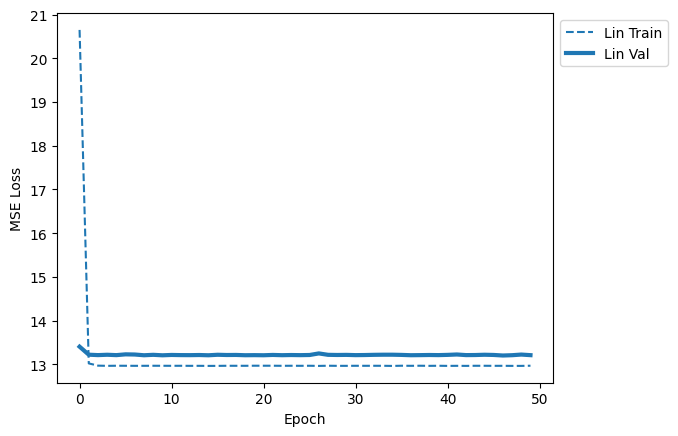

In [18]:
import matplotlib.pyplot as plt

def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    

lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

E0 | train loss: 14.442 | val loss: 10.083
E1 | train loss: 8.638 | val loss: 6.908
E2 | train loss: 6.395 | val loss: 5.411
E3 | train loss: 4.961 | val loss: 5.148
E4 | train loss: 3.676 | val loss: 3.151
E5 | train loss: 3.005 | val loss: 2.233
E6 | train loss: 2.413 | val loss: 1.782
E7 | train loss: 2.041 | val loss: 2.467
E8 | train loss: 1.561 | val loss: 1.280
E9 | train loss: 1.227 | val loss: 1.053
E10 | train loss: 1.163 | val loss: 1.311
E11 | train loss: 1.185 | val loss: 1.089
E12 | train loss: 1.126 | val loss: 1.308
E13 | train loss: 1.129 | val loss: 1.118
E14 | train loss: 1.039 | val loss: 1.053
E15 | train loss: 0.988 | val loss: 1.170
E16 | train loss: 0.975 | val loss: 1.138
E17 | train loss: 0.960 | val loss: 1.115
E18 | train loss: 0.971 | val loss: 0.965
E19 | train loss: 0.940 | val loss: 1.056
E20 | train loss: 0.929 | val loss: 1.127
E21 | train loss: 0.921 | val loss: 0.955
E22 | train loss: 0.976 | val loss: 0.968
E23 | train loss: 0.895 | val loss: 0.953


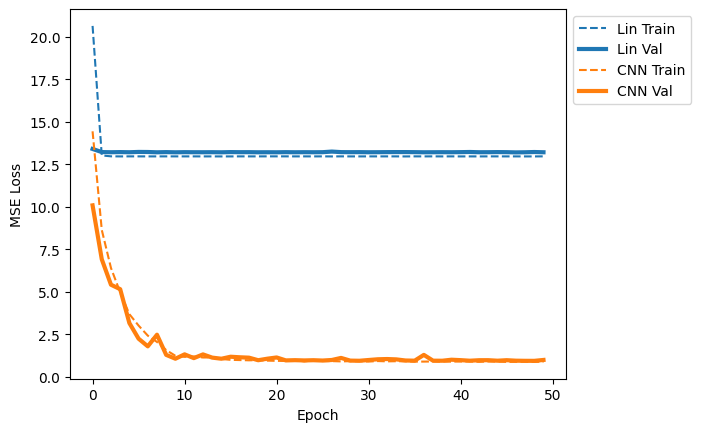

In [19]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE
)

cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

In [20]:
# oracle dict of true score for each seq
oracle = dict(mer8[['seq','score']].values)

def quick_seq_pred(model, desc, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    '''
    print(f"__{desc}__")
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = pred.item() - actual
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

def quick_8mer_pred(model, oracle):
    seqs1 = ("poly-X seqs",['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT'])
    seqs2 = ("other seqs", ['AACCAACA','CCGGTGAG','GGGTAAGG', 'TTTCGTTT'])
    seqsTAT = ("with TAT motif", ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT'])
    seqsGCG = ("with GCG motif", ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT'])
    TATGCG =  ("both TAT and GCG",['ATATGCGA','TGCGTATT'])

    for desc,seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred(model, desc, seqs, oracle)
        print()
        
# Ask the trained Linear model to make 
# predictions for some 8-mers
quick_8mer_pred(model_lin, oracle)

__poly-X seqs__
AAAAAAAA: pred:23.310 actual:20.000 (3.310)
CCCCCCCC: pred:13.703 actual:17.000 (-3.297)
GGGGGGGG: pred:7.152 actual:14.000 (-6.848)
TTTTTTTT: pred:17.730 actual:11.000 (6.730)

__other seqs__
AACCAACA: pred:18.859 actual:18.875 (-0.016)
CCGGTGAG: pred:12.294 actual:15.125 (-2.831)
GGGTAAGG: pred:13.910 actual:15.125 (-1.215)
TTTCGTTT: pred:14.892 actual:12.125 (2.767)

__with TAT motif__
TATAAAAA: pred:22.264 actual:27.750 (-5.486)
CCTATCCC: pred:17.060 actual:25.875 (-8.815)
GTATGGGG: pred:12.170 actual:24.000 (-11.830)
TTTATTTT: pred:18.281 actual:22.125 (-3.844)

__with GCG motif__
AAGCGAAA: pred:17.025 actual:8.125 (8.900)
CGCGCCCC: pred:12.353 actual:6.250 (6.103)
GGGCGGGG: pred:8.127 actual:4.375 (3.752)
TTGCGTTT: pred:12.976 actual:2.500 (10.476)

__both TAT and GCG__
ATATGCGA: pred:15.823 actual:15.875 (-0.052)
TGCGTATT: pred:14.764 actual:13.625 (1.139)



In [21]:
quick_8mer_pred(model_cnn, oracle)

__poly-X seqs__
AAAAAAAA: pred:20.192 actual:20.000 (0.192)
CCCCCCCC: pred:17.184 actual:17.000 (0.184)
GGGGGGGG: pred:14.147 actual:14.000 (0.147)
TTTTTTTT: pred:11.261 actual:11.000 (0.261)

__other seqs__
AACCAACA: pred:19.135 actual:18.875 (0.260)
CCGGTGAG: pred:15.430 actual:15.125 (0.305)
GGGTAAGG: pred:15.494 actual:15.125 (0.369)
TTTCGTTT: pred:12.126 actual:12.125 (0.001)

__with TAT motif__
TATAAAAA: pred:26.634 actual:27.750 (-1.116)
CCTATCCC: pred:25.260 actual:25.875 (-0.615)
GTATGGGG: pred:23.661 actual:24.000 (-0.339)
TTTATTTT: pred:21.121 actual:22.125 (-1.004)

__with GCG motif__
AAGCGAAA: pred:9.384 actual:8.125 (1.259)
CGCGCCCC: pred:7.524 actual:6.250 (1.274)
GGGCGGGG: pred:5.627 actual:4.375 (1.252)
TTGCGTTT: pred:3.734 actual:2.500 (1.234)

__both TAT and GCG__
ATATGCGA: pred:15.823 actual:15.875 (-0.052)
TGCGTATT: pred:13.802 actual:13.625 (0.177)



Running Linear


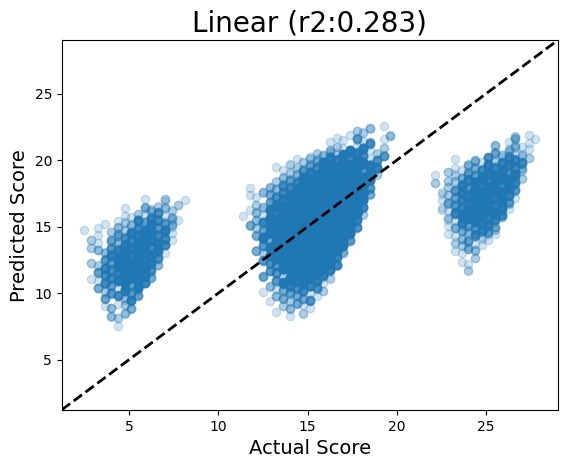

Running CNN


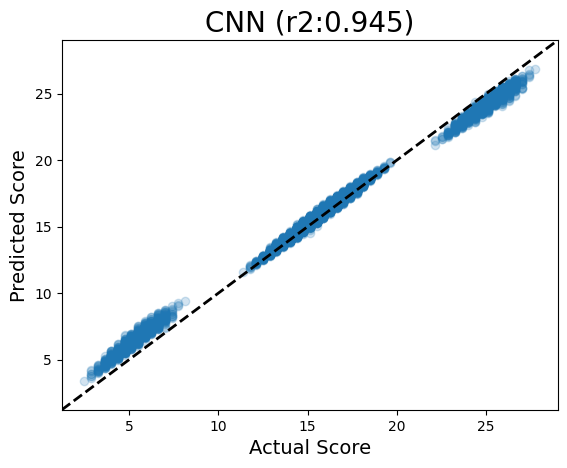

In [24]:
import altair as alt
from sklearn.metrics import r2_score

def parity_plot(model_name,df,r2):
    '''
    Given a dataframe of samples with their true and predicted values,
    make a scatterplot.
    '''
    plt.scatter(df['truth'].values, df['pred'].values, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.ylim(xpoints)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.xlabel("Actual Score",fontsize=14)
    plt.title(f"{model_name} (r2:{r2:.3f})",fontsize=20)
    plt.show()
    
def alt_parity_plot(model,df, r2):
    '''
    Make an interactive parity plot with altair
    '''
    chart = alt.Chart(df).mark_circle(size=100,opacity=0.4).encode(
        alt.X('truth:Q'),
        alt.Y('pred:Q'),
        tooltip=['seq:N']
    ).properties(
        title=f'{model} (r2:{r2:.3f})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{model}.html')
    display(chart)

def parity_pred(models, seqs, oracle,alt=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        r2 = r2_score(df['truth'],df['pred'])
        dfs[model_name] = (r2,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot(model_name, df, r2)
        else:
            parity_plot(model_name, df, r2)
            
# generate plots
seqs = test_df['seq'].values
models = [
    ("Linear", model_lin),
    ("CNN", model_cnn)
]
parity_pred(models, seqs, oracle)